In [1]:
import pandas as pd
import numpy as np
import os
import json
import joblib

import altair as alt
import vegafusion as vf

pd.options.mode.copy_on_write = True
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [2]:
# Pre-define chart function
def chart(df, x, y, title, color=alt.value('steelblue'), width=480, height=320):
    return alt.Chart(df).encode(
        x=x,
        y=y,
        color=color,
    ).properties(
    title=title,
    width=width,
    height=height,
).configure(
    axis=alt.AxisConfig(
        domain=False, # remove axis line
        ticks=False, # remove ticks
        labelAngle=0, # rotate labels
        labelColor='gray', # color of labels
        labelFontSize=10,
    ),
    font='Helvetica Neue',
    view=alt.ViewConfig(stroke=None), # remove border
)

## 1 - Load the training data

In [3]:
input_path = os.path.join('..', 'data', 'cleaned')

train_df = pd.read_parquet(os.path.join(input_path, 'train.parquet'))
train_df.head()

,file,VMONTH,VYEAR,VDAYR,AGE,AGER,SEX,ETHNIC,RACE,USETOBAC,...,REFOTHMD,RETAPPT,OTHDISP,ERADMHOS,RFV1_TEXT,RFV2_TEXT,RFV3_TEXT,DIAG1_TEXT,DIAG2_TEXT,DIAG3_TEXT
0,opd2006,12,2006,6,55,4,2,2,1,1,...,0,0,0,0,"Injury, other and unspecified, of sho...",None,None,"Shoulder and upper arm injury, other ...",None,None
1,opd2006,11,2006,5,66,5,2,2,1,1,...,0,0,0,0,Cough,None,None,"Bronchitis, not specified as acute or...",None,None
2,opd2006,11,2006,4,71,5,1,2,1,1,...,1,0,0,0,General ill feeling,Abnormal eye movements,None,Dizziness and giddiness,"Diabetes mellitus w/o complication, t...",Unspecified essential hypertension
3,opd2006,11,2006,3,1,1,1,2,1,1,...,0,0,0,0,Other and unspecified symptoms refera...,None,None,Unspecified otitis media,Acute upper respiratory infections of...,Chronic rhinitis
4,opd2006,11,2006,2,21,2,1,2,1,2,...,0,0,0,0,Throat soreness,Sinus problems,None,Unspecified sinusitis (chronic),None,None


## 2 - Load the vairiables dictionary and define features for clustering

In [4]:
# Load the variables dictionary
with open(os.path.join(input_path, 'variables.json'), 'r') as f:
    variables = json.load(f)

print(f'Variable Categories:\n')
for category, list in variables.items():
    print(f'{category}')
    print(f'{list}')

Variable Categories:

dateOfVisit
['VMONTH', 'VYEAR', 'VDAYR']
demographics
['AGE', 'AGER', 'SEX', 'ETHNIC', 'RACE', 'USETOBAC']
payment
['PAYPRIV', 'PAYMCARE', 'PAYMCAID', 'PAYWKCMP', 'PAYSELF', 'PAYNOCHG', 'PAYOTH', 'PAYDK', 'PAYTYPER']
visitReason
['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
patientClinicHistory
['SENBEFOR', 'PASTVIS']
vitalSigns
['HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
imputedFields
['BDATEFL', 'SEXFL', 'SENBEFL', 'PASTFL']
physicianDiagnoses
['DIAG1', 'DIAG2', 'DIAG3']
differentialDiagnoses
['PRDIAG1', 'PRDIAG2', 'PRDIAG3']
presentSymptomsStatus
['ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS']
services
['BREAST', 'PELVIC', 'RECTAL', 'SKIN', 'DEPRESS', 'BONEDENS', 'MAMMO', 'MRI', 'ULTRASND', 'XRAY', 'OTHIMAGE', 'CBC', 'GLUCOSE', 'HGBA', 'CHOLEST', 'PSA', 'OTHERBLD', 'BIOPSY', 'CHLAMYD', 'PAPCONV', 'PAPLIQ', 'PAPUNSP', 'HPVDNA', 'EKG', 'URINE', 'HTTAKE', 'WTTAKE

### 2.1 Defining features

##### !!! The statistical test result of the features should be referred first

In [5]:
train_df[variables['visitReason']].value_counts()

INJDET  MAJOR  RFV1   RFV2   RFV3 
5       2      48000  44100  41150    40
1       2      23200  48000  44100    25
5       1      10100  14400  14000    21
               14400  14000  14551    21
1       3      46050  47350  11500    20
                                      ..
5       1      14400  15950  15300     1
                             14750     1
                             10200     1
                      15702  41150     1
        5      89980  45650  42050     1
Name: count, Length: 7796, dtype: int64

In [6]:
# Defining the independent variables as features for classification
features = \
    ['AGE', 'AGER', 'SEX', 'USETOBAC'] + variables['visitReason'] + ['PASTVIS'] + variables['vitalSigns'] \
    + variables['presentSymptomsStatus'] + variables['textFeature']

print(f'Features: {features}')
print(f'Number of Features: {len(features)}')

Features: ['AGE', 'AGER', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT', 'DIAG1_TEXT', 'DIAG2_TEXT', 'DIAG3_TEXT']
Number of Features: 37


In [7]:
X_train = train_df.loc[:, features].copy()

## 3 - Preprocess and engineer the features

 ### 3.1 - Bin the Reason for Visit variables into Modules
 RFV1, RFV2, RFV3

In [8]:
# Load the REASON FOR VISIT classification summary of codes
rfv_summary = pd.read_excel(os.path.join('..', 'data', 'raw', 'RFV_codes_summary.xlsx'))

# Split the 'CODE NUMBER' column into 'START' and 'END' columns
rfv_summary[['START', 'END']] = rfv_summary['CODE NUMBER'].str.split('-', expand=True).astype(int)

# Remove the leading and trailing whitespaces from `MODULE_1` and `MODULE_2` columns
rfv_summary['MODULE_1'] = rfv_summary['MODULE_1'].str.strip()
rfv_summary['MODULE_2'] = rfv_summary['MODULE_2'].str.strip()

rfv_summary.head(5)

,MODULE_1,MODULE_2,CODE NUMBER,START,END
0,SYMPTOM MODULE,General Symptoms,1001-1099,1001,1099
1,SYMPTOM MODULE,Symptoms Referable to Psychological and Mental...,1100-1199,1100,1199
2,SYMPTOM MODULE,Symptoms Referable to the Nervous System (Excl...,1200-1259,1200,1259
3,SYMPTOM MODULE,Symptoms Referable to the Cardiovascular and L...,1260-1299,1260,1299
4,SYMPTOM MODULE,Symptoms Referable to the Eyes and Ears,1300-1399,1300,1399


In [9]:
# Find the `START` and `END` range, 
# and map the corresponding `MODULE_1` and `MODULE_2` to X_train as new columns `MODULE_1` and `MODULE_2`,
# according to the value of `RFV1`, `RFV2`, and `RFV3` columns
def get_module(code):
    module = rfv_summary.loc[(rfv_summary['START'] <= code) & (rfv_summary['END'] >= code), ['MODULE_1', 'MODULE_2']]
    if len(module) == 0:
        return pd.Series([pd.NA, pd.NA], index=['MODULE_1', 'MODULE_2'])
    else:
        return module.iloc[0]



X_train[['RFV1_MOD1', 'RFV1_MOD2']] = X_train['RFV1'].apply(lambda x: get_module(int(str(x)[:4])) if pd.notna(x) else pd.Series([pd.NA, pd.NA], index=['MODULE_1', 'MODULE_2']))
print(f'RFV1 unique values: \n{X_train["RFV1_MOD2"].value_counts()}')

X_train[['RFV2_MOD1', 'RFV2_MOD2']] = X_train['RFV2'].apply(lambda x: get_module(int(str(x)[:4])) if pd.notna(x) else pd.Series([pd.NA, pd.NA], index=['MODULE_1', 'MODULE_2']))
print(f'RFV2 unique values: \n{X_train["RFV2_MOD2"].value_counts()}')

X_train[['RFV3_MOD1', 'RFV3_MOD2']] = X_train['RFV3'].apply(lambda x: get_module(int(str(x)[:4])) if pd.notna(x) else pd.Series([pd.NA, pd.NA], index=['MODULE_1', 'MODULE_2']))
print(f'RFV3 unique values: \n{X_train["RFV3_MOD2"].value_counts()}')

RFV1 unique values: 
RFV1_MOD2
Progress Visit, NEC                                                  9641
Symptoms Referable to the Musculoskeletal System                     8232
Special Examinations                                                 7416
General Examinations                                                 6895
Symptoms Referable to the Respiratory System                         5908
General Symptoms                                                     4536
Injury by Type and/or Location                                       4312
Symptoms Referable to Psychological and Mental Disorders             4048
Symptoms Referable to the Genitourinary System                       3847
Diagnostic Tests                                                     3801
Symptoms Referable to the Digestive System                           3301
Preoperative and Postoperative Care                                  2971
Symptoms Referable to the Skin, Nails, and Hair                      2845
Symptom

### 3.2 - Binning of quantitative variables to categorical features
Bin the following quantitative variables:

AGE, BMI, TEMPF, BPSYS, BPDIAS

#### 3.2.1 - Bin the AGE variable
Do we bin as recoded age groups (`AGER`) or as each 20 years?

In [10]:
# Check the distribution of `AGER`
# 1 = Under 15 years 
# 2 = 15-24 years 
# 3 = 25-44 years 
# 4 = 45-64 years 
# 5 = 65-74 years 
# 6 = 75 years and over|
 
chart(
    df=train_df,
    x='AGER:O',
    y='count()',
    title='Distribution of AGER',
).mark_bar().interactive()

alt.Chart(...)

In [11]:
# Bin the AGE variable as age groups
# 0-2 = Infant
# 2-4 = Toddler
# 4-12 = Child
# 12-20 = Teenager
# 20-40 = Adult
# 40-60 = Middle Aged
# >= 60 = Senior

age_groups = ['Infant', 'Toddler', 'Child', 'Teenager', 'Child or Teenager', 'Adult', 'Middle Aged', 'Senior']

def bin_age(age):
    if pd.isna(age): return pd.NA
    #if age < 2: return 'Infant'
    #elif age < 4: return 'Toddler'
    #elif age < 12: return 'Child'
    #elif age < 20: return 'Teenager'
    elif age < 20: return 'Child or Teenager'
    elif age < 40: return 'Adult'
    elif age < 60: return 'Middle Aged'
    else: return 'Senior'
    

X_train['AGE_GROUP'] = X_train['AGE'].apply(bin_age)

# Check the distribution of age groups
chart(
    df=X_train,
    x=alt.X('AGE_GROUP:O', sort=age_groups),
    y='count()',
    title='Distribution of AGE GROUPS',
).mark_bar().interactive()

alt.Chart(...)

#### 3.2.2 - Bin the vitalSigns variables
BMI, TEMPF, BPSYS, BPDIAS

In [12]:
# Bin the BMI as weight status
# <18.5 = Underweight
# 18.5-25 = Normal weight
# 25-30 = Overweight
# >=30 = Obesity

bmi_groups = ['Underweight', 'Normal weight', 'Overweight', 'Obesity']

def bin_bmi(bmi):
    if pd.isna(bmi): return pd.NA
    elif bmi < 18.5: return 'Underweight'
    elif bmi < 25: return 'Normal weight'
    elif bmi < 30: return 'Overweight'
    else: return 'Obesity'

X_train['BMI_GROUP'] = X_train['BMI'].apply(bin_bmi)

# Check the distribution of BMI groups
chart(
    df=X_train,
    x=alt.X('BMI_GROUP:O', sort=bmi_groups),
    y='count()',
    title='Distribution of BMI GROUPS',
).mark_bar().interactive()

alt.Chart(...)

In [13]:
# Bin the TEMPF as fever status
# <95 = Hypothermia
# 95-99 = Normal temperature
# 99-100 = Low grade fever
# 100-103 = Fever
# >=103 = Hyperpyrexia

tempf_groups = ['Hypothermia', 'Normal temperature', 'Low grade fever', 'Fever', 'Hyperpyrexia']

def bin_tempf(tempf):
    if pd.isna(tempf): return pd.NA
    elif tempf < 95: return 'Hypothermia'
    elif tempf < 99: return 'Normal temperature'
    #elif tempf < 100: return 'Low grade fever'
    elif tempf < 103: return 'Fever'
    else: return 'Hyperpyrexia'

X_train['TEMPF_GROUP'] = X_train['TEMPF'].apply(bin_tempf)

# Check the distribution of TEMPF groups
chart(
    df=X_train,
    x=alt.X('TEMPF_GROUP:O', sort=tempf_groups),
    y='count()',
    title='Distribution of TEMPF GROUPS',
).mark_bar().interactive()

alt.Chart(...)

In [14]:
# Bin the BPSYS as systolic blood pressure status
# <90 = Hypotension
# 90-120 = Normal blood pressure
# 120-140 = Prehypertension
# >=140 = Hypertension

bpsys_groups = ['Hypotension', 'Normal blood pressure', 'Prehypertension', 'Hypertension']

def bin_bpsys(bpsys):
    if pd.isna(bpsys): return pd.NA
    elif bpsys < 90: return 'Hypotension'
    elif bpsys < 120: return 'Normal blood pressure'
    elif bpsys < 140: return 'Prehypertension'
    else: return 'Hypertension'

X_train['BPSYS_GROUP'] = X_train['BPSYS'].apply(bin_bpsys)

# Check the distribution of BPSYS groups
chart(
    df=X_train,
    x=alt.X('BPSYS_GROUP:O', sort=bpsys_groups),
    y='count()',
    title='Distribution of BPSYS GROUPS',
).mark_bar().interactive()

alt.Chart(...)

In [15]:
# Bin the BPDIAS as diastolic blood pressure status
# <60 = Low diastolic blood pressure
# 60-90 = Normal diastolic blood pressure
# 90-110 = High diastolic blood pressure
# >=110 = Hypertension

bpdias_groups = [
    'Low diastolic blood pressure', 'Normal diastolic blood pressure', 'High diastolic blood pressure', 'Hypertension'
]

def bin_bpdias(bpdias):
    if pd.isna(bpdias): return pd.NA
    elif bpdias < 60: return 'Low diastolic blood pressure'
    elif bpdias < 90: return 'Normal diastolic blood pressure'
    elif bpdias < 110: return 'High diastolic blood pressure'
    else: return 'Hypertension'

X_train['BPDIAS_GROUP'] = X_train['BPDIAS'].apply(bin_bpdias)

# Check the distribution of BPDIAS groups
chart(
    df=X_train,
    x=alt.X('BPDIAS_GROUP:O', sort=bpdias_groups),
    y='count()',
    title='Distribution of BPDIAS GROUPS',
).mark_bar().interactive().configure_axisX(labelAngle=45)

alt.Chart(...)

### 3.3 - Create interaction features
AGE, HTIN, WTLB, BMI, BPSYS, BPDIAS, CEBVD, CHF, DIABETES, HYPLIPID, HTN, OBESITY

### 3.4 - Redefine the features for training

In [16]:
binary_features = [feature for feature in features if X_train[feature].nunique() == 2]
print(f'Binary Features: {binary_features}')

ordinal_features = ['CASTAGE']
print(f'Ordinal Features: {ordinal_features}')
print()

# With Binned Groups
quantitative_features_w_bin = ['PASTVIS', 'HTIN', 'WTLB']
print(f'Quantitative Features with Binned Groups: {quantitative_features_w_bin}')

nominal_features_w_bin = ['INJDET', 'MAJOR'] + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2'] + ['AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
print(f'Nominal Features with Binned Groups: {nominal_features_w_bin}')

print(f'Number of Features with Binned Groups: {len(quantitative_features_w_bin + binary_features + ordinal_features + nominal_features_w_bin)}')
print()

# Without Binned Groups
quantitative_features_wo_bin = ['AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
print(f'Quantitative Features without Binned Groups: {quantitative_features_wo_bin}')
nominal_features_wo_bin = ['INJDET', 'MAJOR'] + ['RFV1', 'RFV2', 'RFV3']
print(f'Nominal Features without Binned Groups: {nominal_features_wo_bin}')

print(f'Number of Features without Binned Groups: {len(quantitative_features_wo_bin + binary_features + ordinal_features + nominal_features_wo_bin)}')


Binary Features: ['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS']
Ordinal Features: ['CASTAGE']

Quantitative Features with Binned Groups: ['PASTVIS', 'HTIN', 'WTLB']
Nominal Features with Binned Groups: ['INJDET', 'MAJOR', 'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
Number of Features with Binned Groups: 33

Quantitative Features without Binned Groups: ['AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS']
Nominal Features without Binned Groups: ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3']
Number of Features without Binned Groups: 30


### 3.5 - Handeling missing values in categorical features

In [17]:
# Check the missing values in X_train
print(f'Missing Values in X_train: \n{X_train.isna().sum().where(lambda x: x > 0).dropna()}')
print()

# Fill the missing values in the categorical features
# with -9 for 'CASTAGE',
# with -999 for 'USETOBAC', 'INJDET', 'MAJOR',
# with -9 for 'RFV1', 'RFV2', 'RFV3'
# with 'NA' for 'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2',
# with 'NA' for 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP'
X_train.fillna({'CASTAGE': -9}, inplace=True)
X_train.fillna({'USETOBAC': -999, 'INJDET': -999, 'MAJOR': -999}, inplace=True)
X_train.fillna({'RFV1': -9, 'RFV2': -9, 'RFV3': -9}, inplace=True)
X_train.fillna(
    {
        'RFV1_MOD1': 'NA', 'RFV2_MOD1': 'NA', 'RFV3_MOD1': 'NA',
        'RFV1_MOD2': 'NA', 'RFV2_MOD2': 'NA', 'RFV3_MOD2': 'NA',
        'BMI_GROUP': 'NA', 'TEMPF_GROUP': 'NA', 'BPSYS_GROUP': 'NA', 'BPDIAS_GROUP': 'NA'
    },
    inplace=True
)


# Check the missing values in X_train after filling
print(f'Missing Values in X_train after Filling: \n{X_train.isna().sum().where(lambda x: x > 0).dropna()}')

Missing Values in X_train: 
USETOBAC         40100.0
INJDET           32459.0
MAJOR             2103.0
RFV1              1268.0
RFV2             67179.0
RFV3             90754.0
PASTVIS          19878.0
HTIN             56172.0
WTLB             34554.0
BMI              65377.0
TEMPF            57028.0
BPSYS            40808.0
BPDIAS           40923.0
CASTAGE         100260.0
RFV1_TEXT         1268.0
RFV2_TEXT        67179.0
RFV3_TEXT        90754.0
DIAG1_TEXT         786.0
DIAG2_TEXT       52698.0
DIAG3_TEXT       79620.0
RFV1_MOD1         1268.0
RFV1_MOD2         1268.0
RFV2_MOD1        67179.0
RFV2_MOD2        67179.0
RFV3_MOD1        90754.0
RFV3_MOD2        90754.0
BMI_GROUP        65377.0
TEMPF_GROUP      57028.0
BPSYS_GROUP      40808.0
BPDIAS_GROUP     40923.0
dtype: float64

Missing Values in X_train after Filling: 
PASTVIS       19878.0
HTIN          56172.0
WTLB          34554.0
BMI           65377.0
TEMPF         57028.0
BPSYS         40808.0
BPDIAS        40923.0
RFV1_TEXT 

## 4 - Prepare dependent variables

In [18]:
# Check the missing values in 'DIAG1', 'DIAG2', and 'DIAG3'
print(f'Missing Values in DIAG1: {train_df["DIAG1"].isna().sum()}')
print(f'Missing Values in DIAG2: {train_df["DIAG2"].isna().sum()}')
print(f'Missing Values in DIAG3: {train_df["DIAG3"].isna().sum()}')
print()

# Check the numbers of ruled out or questionable diagnoses
# (when 'PRDIAG1', 'PRDIAG2', and 'PRDIAG3' equals to 1)
print(f'Number of Ruled Out Diagnoses in DIAG1: {train_df["PRDIAG1"].sum()}')
print(f'Number of Ruled Out Diagnoses in DIAG2: {train_df["PRDIAG2"].sum()}')
print(f'Number of Ruled Out Diagnoses in DIAG3: {train_df["PRDIAG3"].sum()}')
print()

# Check the number of samples with missing 'DIAG1' and 'PRDIAG1' equals to 1
print(f'Number of Samples with Missing DIAG1 and PRDIAG1 equals to 1: {train_df[(train_df["DIAG1"].isna()) & (train_df["PRDIAG1"] == 1)].shape[0]}')
print()

# Check the number of available dependent samples
# (when 'DIAG1' is not missing and 'PRDIAG1' is not 1)
print(f'Number of Available Dependent Samples: {train_df[(~train_df["DIAG1"].isna()) & (train_df["PRDIAG1"] != 1)].shape[0]}')

Missing Values in DIAG1: 1444
Missing Values in DIAG2: 53134
Missing Values in DIAG3: 79860

Number of Ruled Out Diagnoses in DIAG1: 940
Number of Ruled Out Diagnoses in DIAG2: 1054
Number of Ruled Out Diagnoses in DIAG3: 493

Number of Samples with Missing DIAG1 and PRDIAG1 equals to 1: 5

Number of Available Dependent Samples: 101107


### 4.1 - Load and the list of three-digit categories of ICD-9-CM

In [19]:
# Load the list of three-digit categories of ICD-9-CM
icd9cm_3dcat = pd.read_excel(os.path.join('..', 'data', 'raw', 'ICD9CM_3DCat.xlsx'), dtype=str)

icd9cm_3dcat.head()

,3D_CODE,DISEASE,CATEGORY_1,CATEGORY_2
0,001,Cholera,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
1,002,Typhoid and paratyphoid fevers,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
2,003,Other salmonella infections,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
3,004,Shigellosis,INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases
4,005,Other food poisoning (bacterial),INFECTIOUS AND PARASITIC DISEASES,Intestinal infectious diseases


### 4.2 - Employing the hierachical classifications of ICD-9-CM codes to prepare the target labels

In [20]:
# Map the three-digit categories of ICD-9-CM to 'DIAG1', 'DIAG2', and 'DIAG3',
# if 'PRDIAG1', 'PRDIAG2', and 'PRDIAG3' are not 1 respectively

def get_icd9cm_3dcat(diag, prdiag, category='CATEGORY_1'):
    try:
        if pd.notna(diag) and (pd.isna(prdiag) | prdiag != 1):
            if diag == 'V997-':
                return 'No diagnosis/disease or healthy'
            else:
                return icd9cm_3dcat[icd9cm_3dcat['3D_CODE'] == diag[:3]][category].values[0]
        else:
            return pd.NA
    except:
        print(f'Error: {diag}')
        print(f'Error: {prdiag}')

    
get_icd9cm_3dcat(train_df.iloc[0].DIAG1, train_df.iloc[0].PRDIAG1, category='CATEGORY_2')

'Certain traumatic complications and unspecified injuries'

In [21]:
# Map the three-digit categories of ICD-9-CM to 'DIAG1', 'DIAG2', and 'DIAG3',
# if 'PRDIAG1', 'PRDIAG2', and 'PRDIAG3' are not 1 respectively

y_train = train_df.apply(lambda x: get_icd9cm_3dcat(x.DIAG1, x.PRDIAG1, category='CATEGORY_1'), axis=1)
y_train_cat2 = train_df.apply(lambda x: get_icd9cm_3dcat(x.DIAG1, x.PRDIAG1, category='CATEGORY_2'), axis=1)

print(f'Dependent DataFrame with CATEGORY_1 Shape: {y_train.shape}')
print(f'Dependent DataFrame with CATEGORY_2 Shape: {y_train_cat2.shape}')

Dependent DataFrame with CATEGORY_1 Shape: (103486,)
Dependent DataFrame with CATEGORY_2 Shape: (103486,)


### 4.3 - Drop the rows from both X_train, y_train with NA in y_train

In [22]:
print(f'Number of available dependent samples: {y_train.notna().sum()}')
print()

non_missing_mask = y_train.notna()

X_train = X_train.loc[non_missing_mask]

y_train = y_train.loc[non_missing_mask]
y_train_cat2 = y_train_cat2[non_missing_mask]

print(f'X_train Shape: {X_train.shape}')
print(f'y_train with CATEGORY_1 Shape: {y_train.shape}')
print(f'y_train with CATEGORY_2 Shape: {y_train_cat2.shape}')

Number of available dependent samples: 101107

X_train Shape: (101107, 48)
y_train with CATEGORY_1 Shape: (101107,)
y_train with CATEGORY_2 Shape: (101107,)


### 4.4 - Add in text feature
From 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT'

From combined textual feature

#### 4.4.1 - Generate text feature with LDA (Topic probabilities)

In [23]:
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

random_state = 42

In [24]:
# Combine 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT' into 'RFV_TEXT'
X_train['RFV_TEXT'] = X_train['RFV1_TEXT'].fillna('') + '. ' + X_train['RFV2_TEXT'].fillna('') + '. ' + X_train['RFV3_TEXT'].fillna('')

In [25]:
# Preprocess the text features with Spacy
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct])

X_train['RFV_TEXT'] = X_train['RFV_TEXT'].apply(preprocess_text)

In [26]:
# Topic modeling with sklearn

# Define the count vectorizer
vectorizer = TfidfVectorizer(
    #stop_words='english',
    ngram_range=(1, 1),
    max_features=1000,
    min_df=5,
    max_df=0.5,
)

tf = vectorizer.fit_transform(X_train['RFV_TEXT'])

# Define the LDA model
n_components = 10

lda = LatentDirichletAllocation(
    n_components=n_components,
    learning_method='online',
    random_state=random_state,
    n_jobs=-1
)

lda.fit(tf)

n_words = 10

# Define the function to display the top words for each topic
def display_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f'Topic {topic_idx}:')
        print(' '.join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))
        print()


display_topics(lda, vectorizer.get_feature_names_out(), n_words)

# Define the topic features
X_train_topics = lda.transform(tf)
topic_features = [f'TOPIC_{i}' for i in range(X_train_topics.shape[1])]
X_train_topics = pd.DataFrame(X_train_topics, columns=topic_features, index=X_train.index)

Topic 0:
pain ache soreness discomfort hypertension knee lesion leg skin earache

Topic 1:
test unspecified diagnostic skin eye result respiratory rash convulsions heart

Topic 2:
chemotherapy neoplasm loss musculoskeletal unspecified insertion connective anemia feel extremity

Topic 3:
mellitus diabetes pregnancy accident throat diagnose complication chest tract fracture

Topic 4:
congestion fever nasal referable symptom nutritional growth disturbance throat disorder

Topic 5:
medication cough kind unspecified pain discom low soreness ache procedure

Topic 6:
examination medical general routine prenatal counseling baby gynecological blood nos

Topic 7:
progress nos visit cramp abdominal psychotherapy spasm pain foot toe

Topic 8:
injury unspecified multiple breast inoculation prophylactic exhaustion tiredness shortness breath

Topic 9:
postoperative visit disease symptom depression specify problem preoperative unsp nervousness



#### 4.4.2 - Visualize the topics

In [27]:
# Visualize the topics with pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()

In [28]:
lda_vis = pyLDAvis.lda_model.prepare(lda, tf, vectorizer, mds='tsne')
lda_vis

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6       1.249396  66.790138       1        1  14.918852
7     -68.005028 -19.394348       2        1  12.128145
0      67.391487 -17.813799       3        1  11.070334
1       7.452456  21.386066       4        1  10.136403
3     -23.069260 -11.723775       5        1   9.707857
9     -44.844322  34.196735       6        1   9.350027
5     -23.205078 -60.200787       7        1   8.881101
8      53.155022  33.668602       8        1   8.615534
4      20.862995 -21.592823       9        1   8.294750
2      30.580027 -66.940277      10        1   6.896998, topic_info=            Term         Freq        Total Category  logprob  loglift
532     progress  5428.000000  5428.000000  Default  30.0000  30.0000
224  examination  5185.000000  5185.000000  Default  29.0000  29.0000
726        visit  6658.000000  6658.000000  Default  28.0000  28.0000
468          nos  6383.000000  6383.000000  Default  27.0000  27.0000
420      medical  3301.000000  3301.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
21          anal   145.354303   146.254195  Topic10  -4.4783   2.6679
703  unspecified   311.718358  4574.472787  Topic10  -3.7154  -0.0121
176      disease   219.232783  1995.978914  Topic10  -4.0673   0.4653
0      abdominal   192.405018   887.607914  Topic10  -4.1979   1.1452
656      symptom   193.343795  1901.246613  Topic10  -4.1930   0.3883

[392 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         2  0.781877  abdominal
0        10  0.216312  abdominal
1         4  0.674343   abnormal
1         5  0.324518   abnormal
8         5  0.998376   accident
...     ...       ...        ...
730       6  0.997274   vomiting
735       8  0.995623   weakness
736       1  0.995930     weight
737       5  0.996651   wheezing
742       5  0.998310      wrist

[383 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 1, 2, 4, 10, 6, 9, 5, 3])

#### 4.4.3 - Concatenate the topic features to X_train

In [29]:
X_train = pd.concat([X_train, X_train_topics], axis=1)
print(f'X_train Shape: {X_train.shape}')
X_train.head()

X_train Shape: (101107, 59)


,AGE,AGER,SEX,USETOBAC,INJDET,MAJOR,RFV1,RFV2,RFV3,PASTVIS,...,TOPIC_0,TOPIC_1,TOPIC_2,TOPIC_3,TOPIC_4,TOPIC_5,TOPIC_6,TOPIC_7,TOPIC_8,TOPIC_9
0,55,4,2,1,1,1,55500,-9,-9,4,...,0.038316,0.038325,0.038320,0.038316,0.038318,0.038329,0.038316,0.353362,0.340079,0.038319
1,66,5,2,1,-999,1,14400,-9,-9,1,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000,0.050000,0.050000,0.050000
3,1,1,1,1,-999,1,13650,-9,-9,1,...,0.037663,0.037675,0.037669,0.037663,0.037667,0.037681,0.037663,0.037663,0.037675,0.660978
4,21,2,1,2,-999,1,14551,14100,-9,6,...,0.033859,0.033845,0.033845,0.695372,0.033848,0.033849,0.033845,0.033845,0.033845,0.033848
5,55,4,1,2,-999,4,48000,-9,-9,4,...,0.036670,0.036670,0.036670,0.036671,0.036670,0.036670,0.036671,0.669963,0.036670,0.036674


In [30]:
topic_features = [f'TOPIC_{i}' for i in range(n_components)]
print(f'Topic Features: {topic_features}')

Topic Features: ['TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9']


## 5 - Classification models

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier

random_state = 42

### 5.1 - Model selection

In [32]:
# Setup the pipeline
def set_pipeline(model, binary_features, ordinal_features, nominal_features, quantitative_features, imputer=None, n_neighbors=5, pca=False, ovr=False):
    # Define the column transformer for the independent variables
    preprocessor = ColumnTransformer(
        transformers=[
            ('binary', 'passthrough', binary_features),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), nominal_features),
            ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-9), ordinal_features),
        ]
    )

    if imputer == 'knn':
        preprocessor.transformers.insert(1, ('impute', KNNImputer(n_neighbors=n_neighbors), quantitative_features))

    if ovr:
        model = OneVsRestClassifier(model)

    # Define the pipeline
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler()),
            ('classifier', model),
        ]
    )

    if pca:
        pipeline.steps.insert(2, ('pca', PCA()))

    return pipeline

#### 5.1.1 - Logistic Regression - Baseline model

##### 5.1.1.1 - Logistic Regression - Dropping the quantitative columns with missing values

In [33]:
# With Binned Groups and RFV Modules
quantitative_features = quantitative_features_w_bin
nominal_features = nominal_features_w_bin

features = binary_features + ordinal_features + nominal_features + quantitative_features

# Drop the quantitative columns with missing values
print(f'Dropping columns with missing values: {set(X_train[features].columns) - set(X_train[features].dropna(axis=1).columns)}')
quantitative_features = [feature for feature in quantitative_features if feature in X_train[features].dropna(axis=1).columns]

print()
print(f'Shape of X_train after dropping columns with missing values: {X_train[features].dropna(axis=1).shape}')
print(f'Features after dropping columns with missing values: \n{X_train[features].columns}')
print()

# Define the model
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Dropping columns with missing values: {'WTLB', 'PASTVIS', 'HTIN'}

Shape of X_train after dropping columns with missing values: (101107, 30)
Features after dropping columns with missing values: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1_MOD1', 'RFV2_MOD1',
       'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2', 'AGE_GROUP',
       'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP', 'PASTVIS',
       'HTIN', 'WTLB'],
      dtype='object')



Cross-Validation Scores: [0.52869445 0.53680332 0.53987639 0.54443618 0.53034755]
Mean Cross-Validation Score: 0.5360315770600692


In [34]:
# With original quantitative data and RFV codes
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin

features = binary_features + ordinal_features + nominal_features + quantitative_features

# Drop the quantitative columns with missing values
print(f'Dropping columns with missing values: {set(X_train[features].columns) - set(X_train[features].dropna(axis=1).columns)}')
quantitative_features = [feature for feature in quantitative_features if feature in X_train[features].dropna(axis=1).columns]
print()

print(f'Shape of X_train after dropping columns with missing values: {X_train[features].dropna(axis=1).shape}')
print(f'Features after dropping columns with missing values: \n{X_train[features].columns}')
print()

# Define the model
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Dropping columns with missing values: {'HTIN', 'WTLB', 'BMI', 'PASTVIS', 'TEMPF', 'BPDIAS', 'BPSYS'}

Shape of X_train after dropping columns with missing values: (101107, 23)
Features after dropping columns with missing values: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE',
       'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.53852984 0.55214081 0.55477052 0.54936778 0.54555224]
Mean Cross-Validation Score: 0.5480722413488794


##### 5.1.1.2 - Logistic Regression - Imputing the missing values - KNN Imputer

In [35]:
# With original quantitative data and RFV codes
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
BMI        63726.0
TEMPF      55510.0
BPSYS      39711.0
BPDIAS     39822.0
dtype: float64

Shape of X_train: (101107, 30)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE',
       'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.54803676 0.55830207 0.55730772 0.55290922 0.55274904]
Mean Cross-Validation Score: 0.5538609599098001


In [36]:
# With Binned Groups and RFV codes
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
dtype: float64

Shape of X_train: (101107, 30)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.54182667 0.55799742 0.55331355 0.55729509 0.55220371]
Mean Cross-Validation Score: 0.5525272896282727


In [37]:
# With Binned Groups and RFV codes + RFV Modules
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
dtype: float64

Shape of X_train: (101107, 36)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.54190194 0.55886814 0.55321222 0.55731843 0.5524464 ]
Mean Cross-Validation Score: 0.5527494258410842


In [38]:
# With Binned Groups and RFV codes + RFV Modules + Topic Features
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
dtype: float64

Shape of X_train: (101107, 46)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'PASTVIS', 'HTIN', 'WTLB', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2',
       'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8',
       'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.54190194 0.55886814 0.55321222 0.55731843 0.5524464 ]
Mean Cross-Validation Score: 0.5527494258410842


In [39]:
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=LogisticRegression(
        random_state=random_state, n_jobs=-1,
        max_iter=1000, class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
BMI        63726.0
TEMPF      55510.0
BPSYS      39711.0
BPDIAS     39822.0
dtype: float64

Shape of X_train: (101107, 46)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS',
       'BPDIAS', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4',
       'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.54834843 0.55846154 0.55765823 0.55293542 0.55344217]
Mean Cross-Validation Score: 0.554169156292843


#### 5.1.2 - Random Forest

In [40]:
# With Binned Groups and RFV codes + RFV Modules
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
dtype: float64

Shape of X_train: (101107, 36)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.5834175  0.59604598 0.59463462 0.59516332 0.58043414]
Mean Cross-Validation Score: 0.5899391096559992


In [41]:
# With Binned Groups and RFV codes + RFV Modules + Topic Features
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
dtype: float64

Shape of X_train: (101107, 46)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'PASTVIS', 'HTIN', 'WTLB', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2',
       'TOPIC_3', 'TOPIC_4', 'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8',
       'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.5834175  0.59604598 0.59463462 0.59516332 0.58043414]
Mean Cross-Validation Score: 0.5899391096559992


In [42]:
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
BMI        63726.0
TEMPF      55510.0
BPSYS      39711.0
BPDIAS     39822.0
dtype: float64

Shape of X_train: (101107, 46)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS',
       'BPDIAS', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4',
       'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.59065007 0.60247368 0.60161858 0.60143341 0.59148105]
Mean Cross-Validation Score: 0.5975313554845852


#### 5.1.3 - Multi-layer Perceptron Classifier

In [44]:
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=MLPClassifier(
        #hidden_layer_sizes=(100, 50),
        #activation='tanh',
        #solver='adam',
        #alpha=0.0001,
        #max_iter=1000,
        random_state=random_state
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=2, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
BMI        63726.0
TEMPF      55510.0
BPSYS      39711.0
BPDIAS     39822.0
dtype: float64

Shape of X_train: (101107, 46)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS',
       'BPDIAS', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4',
       'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-Validation Scores: [0.53345936 0.54109116]
Mean Cross-Validation Score: 0.5372752589091688


#### 5.1.4 - Histogram-based Gradient Boosting Classification Tree

In [45]:
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=HistGradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.1,
        max_iter=100,
        max_leaf_nodes=31,
        max_depth=None,
        min_samples_leaf=20,
        l2_regularization=0,
        #max_features=1.0,
        max_bins=255,
        #categorical_features=binary_features + ordinal_features + nominal_features,
        #interaction_cst='pairwise',
        random_state=random_state,
        class_weight='balanced'
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
scores = cross_val_score(
    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
    scoring='f1_weighted'
    #scoring='accuracy'
)

print(f'Cross-Validation Scores: {scores}')
print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
BMI        63726.0
TEMPF      55510.0
BPSYS      39711.0
BPDIAS     39822.0
dtype: float64

Shape of X_train: (101107, 46)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS',
       'BPDIAS', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4',
       'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')



/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/sean7x/miniconda3/lib/pyt

Cross-Validation Scores: [0.57803284 0.58866366 0.58565094 0.59028168 0.57817333]
Mean Cross-Validation Score: 0.584160490460757


#### 5.1.4 - Gradient Boosting Classifier

In [46]:
# With Binned Groups and RFV codes + RFV Modules
quantitative_features = ['PASTVIS', 'HTIN', 'WTLB']
nominal_features = ['INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP']
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

features = binary_features + ordinal_features + nominal_features + quantitative_features

print(f'Missing Values in X_train: \n{X_train[features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[features].shape}')
print(f'Features to be fit: \n{X_train[features].columns}')
print()

# Define the model
n_neighbors = 5
pipeline = set_pipeline(
    model=GradientBoostingClassifier(
        loss='log_loss',
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=3,
        random_state=random_state,
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors
)

# Cross-validate the model
#scores = cross_val_score(
#    pipeline, X_train[features], y_train, cv=5, n_jobs=-1,
#    scoring='f1_weighted'
#    #scoring='accuracy'
#)

#print(f'Cross-Validation Scores: {scores}')
#print(f'Mean Cross-Validation Score: {scores.mean()}')

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
dtype: float64

Shape of X_train: (101107, 36)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'AGE_GROUP', 'BMI_GROUP', 'TEMPF_GROUP', 'BPSYS_GROUP', 'BPDIAS_GROUP',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'PASTVIS', 'HTIN', 'WTLB'],
      dtype='object')



### 5.2 - Model evaluation

In [47]:
# Load custom function to combine text features
import sys
import importlib
sys.path.append('../src/features/')

import build_features
importlib.reload(build_features)

<module 'build_features' from '/Users/sean7x/pathclarity/notebooks/../src/features/build_features.py'>

In [48]:
from sklearn.metrics import accuracy_score, f1_score, label_ranking_average_precision_score, classification_report

In [49]:
input_path = os.path.join('..', 'data', 'cleaned')

# Load the variables dictionary and return the features list
varaibles_path = os.path.join(input_path, 'variables.json')
features = build_features.load_features(varaibles_path)

# Load and clean the REASON FOR VISIT classification summary of codes
rfv_path = os.path.join('..', 'data', 'raw', 'RFV_codes_summary.xlsx')
rfv_df = build_features.load_rfv(rfv_path)

# Load the list of three-digit categories of ICD-9-CM
icd9cm_path = os.path.join('..', 'data', 'raw', 'ICD9CM_3DCat.xlsx')
icd9cm_df = build_features.load_icd9cm(icd9cm_path)

icd9cm_category = 'CATEGORY_1'

Variables keys: dict_keys(['dateOfVisit', 'demographics', 'payment', 'visitReason', 'patientClinicHistory', 'vitalSigns', 'imputedFields', 'physicianDiagnoses', 'differentialDiagnoses', 'presentSymptomsStatus', 'services', 'healthEducation', 'medicationsAndImmunizations', 'providersSeen', 'visitDisposition', 'textFeature'])
Features: ['AGE', 'AGER', 'SEX', 'USETOBAC', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS', 'BPDIAS', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CASTAGE', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT', 'DIAG1_TEXT', 'DIAG2_TEXT', 'DIAG3_TEXT']
Number of Features: 37


#### 5.2.1 - Load and prepare the training dataset

In [50]:
# Load the training dataset
train_df = pd.read_parquet(os.path.join(input_path, 'train.parquet'))

X_train, y_train = build_features.build_features(train_df, features, rfv_df, icd9cm_df, category=icd9cm_category)

Number of available dependent samples: 101107

X_train Shape: (101107, 48)
y_train with CATEGORY_1 Shape: (101107,)


In [55]:
# Combine 'RFV1_TEXT', 'RFV2_TEXT', 'RFV3_TEXT' into 'RFV_TEXT'
X_train['RFV_TEXT'] = X_train['RFV1_TEXT'].fillna('') + '. ' + X_train['RFV2_TEXT'].fillna('') + '. ' + X_train['RFV3_TEXT'].fillna('')

# Preprocess the text features with Spacy
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct])

X_train['RFV_TEXT'] = X_train['RFV_TEXT'].apply(preprocess_text)

# Preprocess the text features with Spacy
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct])

X_train['RFV_TEXT'] = X_train['RFV_TEXT'].apply(preprocess_text)

# Topic modeling with sklearn

# Define the count vectorizer
vectorizer = TfidfVectorizer(
    #stop_words='english',
    ngram_range=(1, 1),
    max_features=1000,
    min_df=5,
    max_df=0.5,
)

tf = vectorizer.fit_transform(X_train['RFV_TEXT'])

# Define the LDA model
n_components = 10

lda = LatentDirichletAllocation(
    n_components=n_components,
    learning_method='online',
    random_state=random_state,
    n_jobs=-1
)

lda.fit(tf)

n_words = 10

# Define the function to display the top words for each topic
def display_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f'Topic {topic_idx}:')
        print(' '.join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))
        print()


display_topics(lda, vectorizer.get_feature_names_out(), n_words)

# Define the topic features
X_train_topics = lda.transform(tf)
topic_features = [f'TOPIC_{i}' for i in range(X_train_topics.shape[1])]
X_train_topics = pd.DataFrame(X_train_topics, columns=topic_features, index=X_train.index)


# Combine the topic features with X_train
X_train = pd.concat([X_train, X_train_topics], axis=1)
print(f'X_train Shape: {X_train.shape}')
X_train.head()

topic_features = [f'TOPIC_{i}' for i in range(n_components)]
print(f'Topic Features: {topic_features}')

Topic 0:
progress visit nos routine examination prenatal gynecological psychotherapy specify unsp

Topic 1:
mellitus diabete skin pregnancy lesion complication breast diagnose earache problem

Topic 2:
disease baby eye examination depression abnormal unspecified psychosis functional movement

Topic 3:
medication unspecified kind hypertension cramp pain abdominal symptom spasm anxiety

Topic 4:
medical general examination counseling nos injury unspecified multiple group accident

Topic 5:
inoculation prophylactic fracture dislocation foot toe vaginal physical mass urination

Topic 6:
throat congestion fever nasal cough convulsion chest cancer tract soreness

Topic 7:
pain ache soreness discomfort discom head headache knee low skin

Topic 8:
postoperative visit chemotherapy neoplasm nausea loss site transplant insertion unspecified

Topic 9:
test unspecified diagnostic result blood cough respiratory asthma upper pressure

X_train Shape: (101107, 59)
Topic Features: ['TOPIC_0', 'TOPIC_1',

In [51]:
# Check the distribution and percentage of the labels in the training dataset
y_train.value_counts(normalize=True)

# Plot the distribution and percentage of true labels
chart(
    df=y_train.value_counts(normalize=True).reset_index(),
    x='index:N',
    y='proportion:Q',
    title='Distribution of the Labels in the Training Dataset',
).mark_bar().interactive().configure_axisX(labelAngle=45)

alt.Chart(...)

##### 5.2.1.1 - Account for the imbalance in the labels

In [52]:
from imblearn.under_sampling import RandomUnderSampler

In [53]:
# Random Undersampling
def random_undersampling(X_train, y_train):
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=random_state)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

    return X_train_resampled, y_train_resampled


#X_train, y_train = random_undersampling(X_train, y_train)

##### 5.2.1.2 - Confirm the distribution and percentage of the labels in the training dataset

In [54]:
# Check the distribution and percentage of the labels in the training dataset
y_train.value_counts(normalize=True)

# Plot the distribution and percentage of true labels
chart(
    df=y_train.value_counts(normalize=True).reset_index(),
    x='index:N',
    y='proportion:Q',
    title='Distribution of the Labels in the Training Dataset',
).mark_bar().interactive().configure_axisX(labelAngle=45)

alt.Chart(...)

#### 5.2.2 - Model training

In [56]:
# Train the model
# With original quantitative data and RFV codes + RFV Modules + Topic Features
quantitative_features = quantitative_features_wo_bin
nominal_features = nominal_features_wo_bin
nominal_features = nominal_features + ['RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1'] + ['RFV1_MOD2', 'RFV2_MOD2', 'RFV3_MOD2']

clf_features = binary_features + ordinal_features + nominal_features + quantitative_features + topic_features

print(f'Missing Values in X_train: \n{X_train[clf_features].isna().sum().where(lambda x: x > 0).dropna()}')
print()
print(f'Shape of X_train: {X_train[clf_features].shape}')
print(f'Features to be fit: \n{X_train[clf_features].columns}')
print()

# Define the model
n_neighbors = 5
clf_pipeline = set_pipeline(
    model=RandomForestClassifier(
        n_estimators=1000,
        criterion='entropy',
        #class_weight='balanced',
        n_jobs=-1,
        random_state=random_state
    ),
    binary_features=binary_features,
    ordinal_features=ordinal_features,
    nominal_features=nominal_features,
    quantitative_features=quantitative_features,
    imputer='knn',
    n_neighbors=n_neighbors,
    pca=True,
    #ovr=True
)

clf_model_name = clf_pipeline.named_steps['classifier'].__class__.__name__
if 'one' in clf_model_name.lower():
    clf_model_name = f'OneVsRest {type(clf_pipeline.esitmator).__name__}'
print(f'Classifier: {clf_model_name}')

clf_pipeline.fit(X_train[clf_features], y_train)

Missing Values in X_train: 
PASTVIS    19227.0
HTIN       54706.0
WTLB       33542.0
BMI        63726.0
TEMPF      55510.0
BPSYS      39711.0
BPDIAS     39822.0
dtype: float64

Shape of X_train: (101107, 46)
Features to be fit: 
Index(['SEX', 'USETOBAC', 'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF',
       'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY',
       'OSTPRSIS', 'CASTAGE', 'INJDET', 'MAJOR', 'RFV1', 'RFV2', 'RFV3',
       'RFV1_MOD1', 'RFV2_MOD1', 'RFV3_MOD1', 'RFV1_MOD2', 'RFV2_MOD2',
       'RFV3_MOD2', 'AGE', 'PASTVIS', 'HTIN', 'WTLB', 'BMI', 'TEMPF', 'BPSYS',
       'BPDIAS', 'TOPIC_0', 'TOPIC_1', 'TOPIC_2', 'TOPIC_3', 'TOPIC_4',
       'TOPIC_5', 'TOPIC_6', 'TOPIC_7', 'TOPIC_8', 'TOPIC_9'],
      dtype='object')

Classifier: RandomForestClassifier


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary', 'passthrough',
                                                  ['SEX', 'USETOBAC',
                                                   'ARTHRTIS', 'ASTHMA',
                                                   'CANCER', 'CEBVD', 'CHF',
                                                   'CRF', 'COPD', 'DEPRN',
                                                   'DIABETES', 'HYPLIPID',
                                                   'HTN', 'IHD', 'OBESITY',
                                                   'OSTPRSIS']),
                                                 ('impute', KNNImputer(),
                                                  ['AGE', 'PASTVIS', 'HTIN',
                                                   'WTLB', 'BMI', 'TEMPF',
                                                   'BPSYS', 'BPDIAS']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'...
                                                  ['INJDET', 'MAJOR', 'RFV1',
                                                   'RFV2', 'RFV3', 'RFV1_MOD1',
                                                   'RFV2_MOD1', 'RFV3_MOD1',
                                                   'RFV1_MOD2', 'RFV2_MOD2',
                                                   'RFV3_MOD2']),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-9),
                                                  ['CASTAGE'])])),
                ('scaler', StandardScaler()), ('pca', PCA()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', n_estimators=1000,
                                        n_jobs=-1, random_state=42))])

#### 5.2.3 - Load and prepare the test dataset

In [57]:
# Load the test dataset
test_df = pd.read_parquet(os.path.join(input_path, 'test.parquet'))

X_test, y_test = build_features.build_features(test_df, features, rfv_df, icd9cm_df, category=icd9cm_category)

Number of available dependent samples: 34040

X_train Shape: (34040, 48)
y_train with CATEGORY_1 Shape: (34040,)


In [58]:
# Check the distribution and percentage of true labels
y_test.value_counts(normalize=True)

# Plot the distribution and percentage of true labels
chart(
    df=y_test.value_counts(normalize=True).reset_index(),
    x='index:N',
    y='proportion:Q',
    title='Distribution of True Labels',
).mark_bar().interactive().configure_axisX(labelAngle=45)

alt.Chart(...)

In [59]:
# Add the topic features to the test dataset
X_test['RFV_TEXT'] = X_test['RFV1_TEXT'].fillna('') + '. ' + X_test['RFV2_TEXT'].fillna('') + '. ' + X_test['RFV3_TEXT'].fillna('')
X_test['RFV_TEXT'] = X_test['RFV_TEXT'].apply(preprocess_text)

tf = vectorizer.transform(X_test['RFV_TEXT'])
X_test_topics = lda.transform(tf)
X_test_topics = pd.DataFrame(X_test_topics, columns=topic_features, index=X_test.index)

X_test = pd.concat([X_test, X_test_topics], axis=1)
print(f'X_test Shape: {X_test.shape}')

X_test Shape: (34040, 59)


#### 5.2.4 - Prediction and Metrics

In [60]:
y_pred = clf_pipeline.predict(X_test)

/Users/sean7x/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [61]:
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
y_pred_encoded = le.transform(y_pred)

n_classes = len(le.classes_)
y_test_binarized = label_binarize(y_test_encoded, classes=range(n_classes))
y_pred_binarized = label_binarize(y_pred_encoded, classes=range(n_classes))

lrap = label_ranking_average_precision_score(y_test_binarized, y_pred_binarized)
print(f'Label Ranking Average Precision Score: {lrap}')

Label Ranking Average Precision Score: 0.5970296383338022


In [62]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Prediction Accuracy: {accuracy}')

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Weighted Prediction F1 Score: {f1}')

print(classification_report(y_test[y_test.notna()], y_pred[y_test.notna()]))

Prediction Accuracy: 0.5733254994124559
Weighted Prediction F1 Score: 0.5608327682682113
                                                                                                    precision    recall  f1-score   support

                                            CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD       0.09      0.03      0.05        64
                                        COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM       0.54      0.27      0.36       809
                                                                              CONGENITAL ANOMALIES       0.53      0.24      0.33       347
                                                        DISEASES OF BLOOD AND BLOOD-FORMING ORGANS       0.59      0.25      0.35       356
                                                                DISEASES OF THE CIRCULATORY SYSTEM       0.49      0.45      0.47      2146
                                                                  DISE

#### 5.2.5 - Confusion matrix

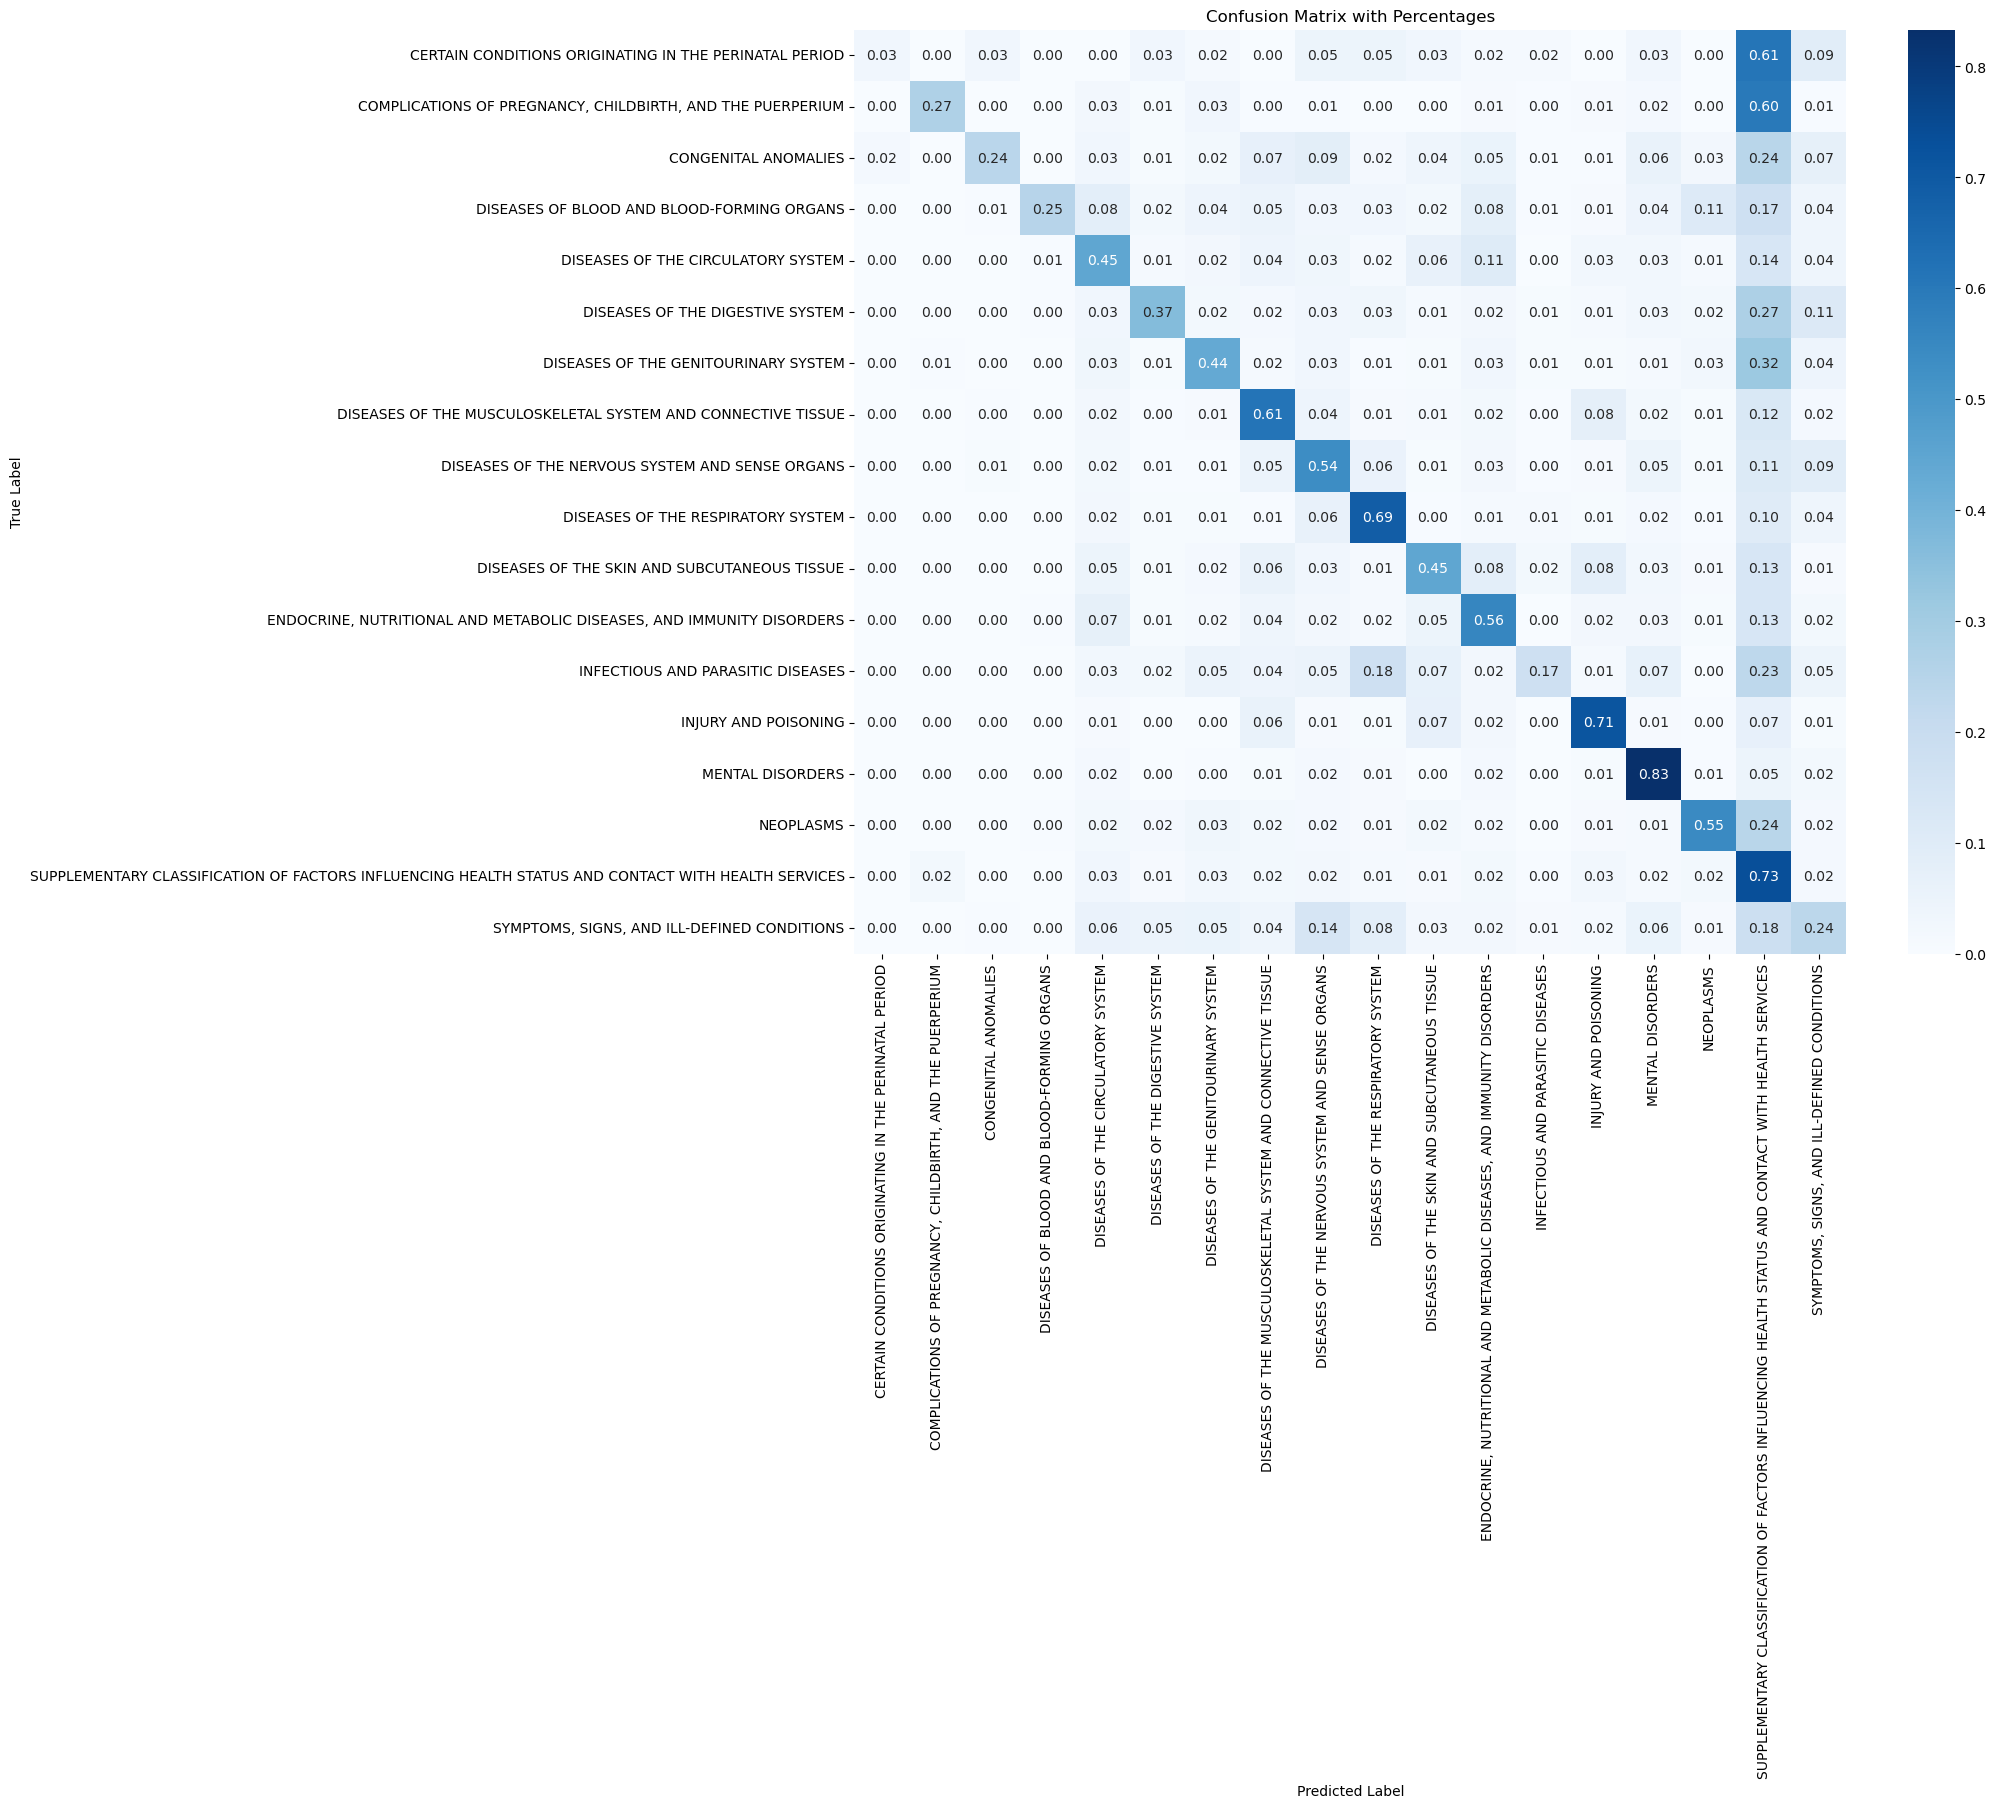

In [63]:
# Plot the confusion matrix with percentages
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16, 12))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=clf_pipeline.classes_, yticklabels=clf_pipeline.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Percentages')
plt.show()

## 6 - Extract text features from each cluster

In [ ]:
# Load custom function to combine text features
import sys
sys.path.append('../src/features/')

from combine_textual import combine_features

#### 6.1 - Aggregate text data by group

In [ ]:
# Define the list of textual features to combine
textual_features = [
    'AGE', 'SEX', 'USETOBAC', 
    'MAJOR', 'RFV1', 'RFV2', 'RFV3', 
    'BMI', 'TEMPF', 'BPSYS', 'BPDIAS',
    'ARTHRTIS', 'ASTHMA', 'CANCER', 'CEBVD', 'CHF', 'CRF', 'COPD', 'DEPRN', 'DIABETES', 'HYPLIPID', 'HTN', 'IHD', 'OBESITY', 'OSTPRSIS', 'NOCHRON', 'DMP',
    'DIAG1', 'DIAG2', 'DIAG3'
]

# Export the list of textual features
with open(os.path.join(file_path, 'textual_features.json'), 'w') as f:
    json.dump(textual_features, f)

# Combine the text features
train_df['CombinedText'] = train_df.apply(lambda x: combine_features(x, textual_features), axis=1)

train_df.CombinedText.head()

In [ ]:
train_df.CombinedText.notna().sum()

#### 6.2 - Preprocess text data

In [ ]:
import spacy
import re

In [ ]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text(row):
    row = re.sub(r'(\d+),(\d+)', r'\1\2', row)
    row = re.sub(r'(\d+)-(\d+)', r'\1_\2', row)
    doc = nlp(row)
    processed_text = ' '.join(token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct)
    row = re.sub(r'(\d+)_(\d+)', r'\1-\2', row)
    return processed_text

In [ ]:
train_df['ProcessedText'] = train_df['CombinedText'].apply(preprocess_text)

In [ ]:
train_df.ProcessedText.head()

In [ ]:
# Save the preprocessed DataFrame
processed_file_path = os.path.join('..', 'data', 'processed')
train_df.to_csv(os.path.join(processed_file_path, f'train_{clustering_model_name}.csv'), index=False)

#### 6.3 - Calculate term frequencies

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Method 1
# Calculate the TF-IDF for each cluster,
# taking the ProcessedText of each cluster as the documents,
# and the ProcessedText of the entire dataset as the corpus

#clustered_text = train_df.groupby('cluster')['ProcessedText'].apply(lambda row: ' '.join(row)).reset_index()

#vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000, min_df=5, max_df=0.7)
#tfidf_matrix = vectorizer.fit_transform(clustered_text['ProcessedText'])

#print(tfidf_matrix)

#tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
#tfidf_df

In [ ]:
# Method 2
# Calculate the TF-IDF of each row within each cluster
# Calculate the average TF-IDF for each cluster

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000, min_df=5, max_df=0.7)
tfidf_matrix = vectorizer.fit_transform(train_df['ProcessedText'])

# Calculate the average TF-IDF for each cluster
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
cluster_tfidf = pd.concat([train_df['cluster'], tfidf_df], axis=1).groupby('cluster').mean()

cluster_tfidf

In [ ]:
# Punish the weight of '\d+_year_old' by multiplying it by 0.5, using the regex pattern

#tfidf_df = tfidf_df.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)
#cluster_tfidf = cluster_tfidf.apply(lambda row: row * 0.5 if re.match(r'\d+_year_old', row.name) else row)

#cluster_tfidf

#### 6.4 - Generate word clouds for each group

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Plot the word cloud for each cluster basd on the average TF-IDF
for i in range(n_clusters):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(cluster_tfidf.loc[i])
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {i}')
    plt.show()

## 7 - Topic modeling

In [ ]:
import gensim
from gensim import corpora

random_seed = 42

In [ ]:
# Generate bigrams
def generate_bigrams(row):
    tokens = row.split()
    bigram_model = gensim.models.Phrases(tokens, min_count=5, threshold=100)
    tokens = [token for token in bigram_model[tokens]]
    return tokens


print(generate_bigrams(train_df['ProcessedText'].iloc[0]))
preprocessed_docs = train_df['ProcessedText'].apply(generate_bigrams)

In [ ]:
# Build dictionary and corpus
dictionary = corpora.Dictionary(preprocessed_docs)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

In [ ]:
# Train LDA model
n_topics = 10

lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=n_topics,
    random_state=random_seed,
    chunksize=100,
    passes=10,
)



### 7.1 - Visualize the topics

In [ ]:
import pyLDAvis.gensim_models
import pyLDAvis

pyLDAvis.enable_notebook()

In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

### 7.2 - Get the topic distribution for each cluster

In [ ]:
# Get the topic distribution for each document 
def get_avg_topic_distribution(cluster_data, topic_distribution, num_topics):
    cluster_topics = np.zeros((len(cluster_data.index), num_topics))

    # Update the distribution with the actual values
    for i, doc_index in enumerate(cluster_data.index.tolist()):
        for topic, prob in topic_distribution[doc_index]:
            cluster_topics[i, topic] = prob

    avg_topic_dist = np.mean(cluster_topics, axis=0)
    return avg_topic_dist


topic_distribution = lda_model.get_document_topics(corpus, minimum_probability=0.0)
clusters = train_df.groupby('cluster').ProcessedText

cluster_topics = []
for cluster, data in clusters:
    avg_topic_dist = get_avg_topic_distribution(data, topic_distribution, lda_model.num_topics)
    cluster_topics.append([avg_topic_dist.tolist()])

cluster_topics_df = pd.DataFrame(cluster_topics, columns=['avg_topic_distribution'])

cluster_topics_df

### 7.3 - Visualize the distribution of topics within each cluster

In [ ]:
import altair as alt

In [ ]:
# Reshape the dataframe to have a row for each cluster and topic
cluster_topics_heatmap_df = cluster_topics_df.avg_topic_distribution.apply(pd.Series).reset_index().rename(columns={'index': 'cluster'}).melt(id_vars='cluster', var_name='topic', value_name='probability')

heatmap = alt.Chart(cluster_topics_heatmap_df).mark_rect().encode(
    x='topic:O',
    y='cluster:O',
    color='probability:Q'
).properties(
    title='Average Topic Distribution for Each Cluster',
    width=400,
    height=400
)

heatmap

## 8 - Medical pathways

In [ ]:
# 'services' features
binary_services = [feature for feature in variables['services'] if train_df[feature].nunique() <= 2]
print(f'Binary Services: {binary_services}')

nominal_services = [feature for feature in variables['services'] if feature not in binary_services]
print(f'Nominal Services: {nominal_services}')
print()

# 'medicationsAndImmunizations' features
quantitative_med = ['NUMNEW', 'NUMCONT']
print(f'Quantitative Medications: {quantitative_med}')

binary_med = [feature for feature in variables['medicationsAndImmunizations'] if train_df[feature].nunique() <= 2 and feature not in quantitative_med]
print(f'Binary Medications: {binary_med}')

nominal_med = [feature for feature in variables['medicationsAndImmunizations'] if feature not in binary_med and feature not in quantitative_med]
print(f'Nominal Medications: {nominal_med}')
print()

# 'providersSeen' features
binary_ps = [feature for feature in variables['providersSeen'] if train_df[feature].nunique() <= 2]
print(f'Binary Providers Seen: {binary_ps}')
print()

# 'visitDisposition' features
binary_vd = [feature for feature in variables['visitDisposition'] if train_df[feature].nunique() <= 2]
print(f'Binary Visit Disposition: {binary_vd}')
print()

# 'DIAG' features
nominal_diag = ['DIAG1', 'DIAG1_CAT1', 'DIAG1_CAT2']
print(f'Nominal Diagnosis: {nominal_diag}')
text_diag = 'DIAG1_TEXT'
print(f'Text Diagnosis: {text_diag}')